https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv


In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 91 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=14f9c46e51a1db4a6bfe4de2c800fa7802618d4b1ac42a84810526c1bbcda06f
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=21b53356f5b79a72b7793749d8cb494e21eda567d7308a6e2f3027242c492aa0
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=a4fbf82b5d84ab395ec73332b613076f8fe48ca4546135d2c5995f6e65112067
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [2]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px

# Import from libraries

In [3]:
data = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', engine="python",
    encoding="latin1")
data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


As our focus will only be the texts so we will delete the attributes that will not be necessary for this study base.

In [4]:
data.drop(['UserName', 'ScreenName', 'Location','TweetAt'], axis = 1, inplace=True)
data

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


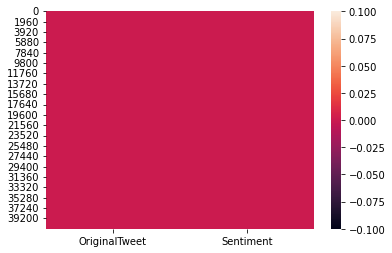

In [5]:
sns.heatmap(data.isnull());

In [6]:
data.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [7]:
data['sentiment'] = data['Sentiment'].map({'Positive': 1,'Negative': -1,'Neutral': 0, 'Extremely Negative': -2, 'Extremely Positive' : 2},
                             na_action=None)

In [8]:
data

,OriginalTweet,Sentiment,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,advice Talk to your neighbours family to excha...,Positive,1
2,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,My food stock is not the only one which is emp...,Positive,1
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-2
...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,0
41153,Response to complaint not provided citing COVI...,Extremely Negative,-2
41154,You know itÂs getting tough when @KameronWild...,Positive,1
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,0


In [9]:
data.drop(['Sentiment'], axis = 1, inplace=True)
data

,OriginalTweet,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,1
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,1
4,"Me, ready to go at supermarket during the #COV...",-2
...,...,...
41152,Airline pilots offering to stock supermarket s...,0
41153,Response to complaint not provided citing COVI...,-2
41154,You know itÂs getting tough when @KameronWild...,1
41155,Is it wrong that the smell of hand sanitizer i...,0


In [10]:
positive = data[data['sentiment'] >= 1 ]
negative = data[data['sentiment'] <= -1]
neutral = data[data['sentiment'] == 0]

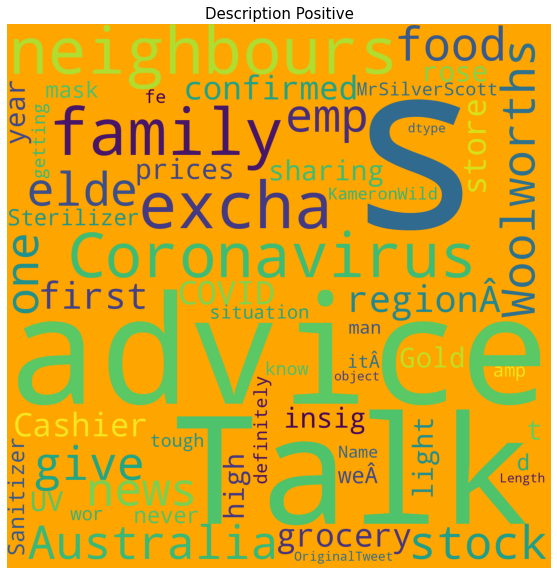

In [11]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(positive['OriginalTweet']))
plt.title('Description Positive', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

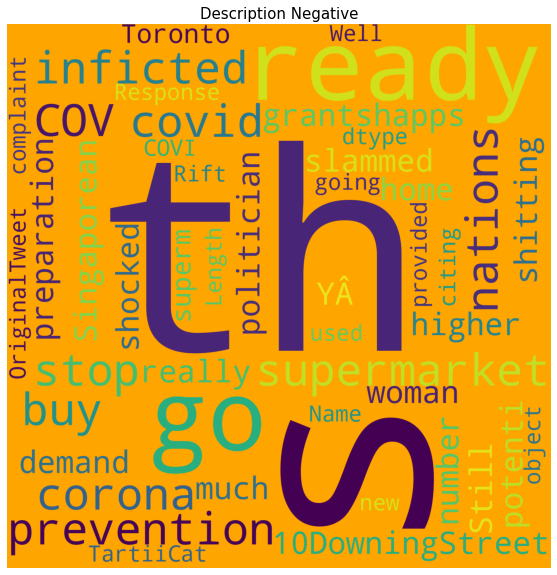

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(negative['OriginalTweet']))
plt.title('Description Negative', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

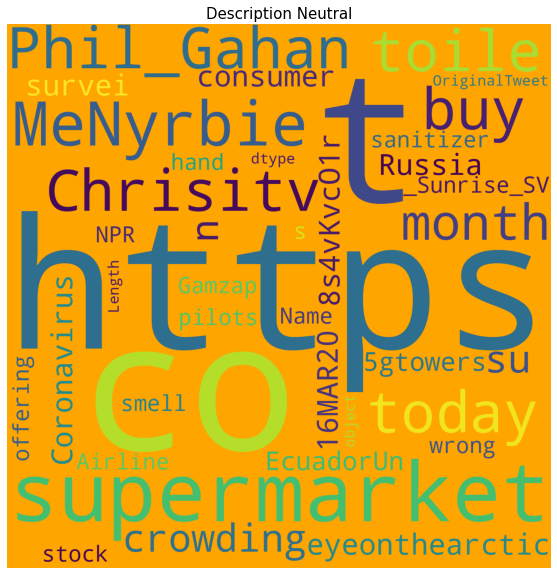

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(neutral['OriginalTweet']))
plt.title('Description Neutral', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

**Numbers in quantities**

In [14]:
fig2 = px.histogram(data,x='sentiment',color='sentiment',template='plotly_dark')
fig2.show()

(0.0, 12564.2)

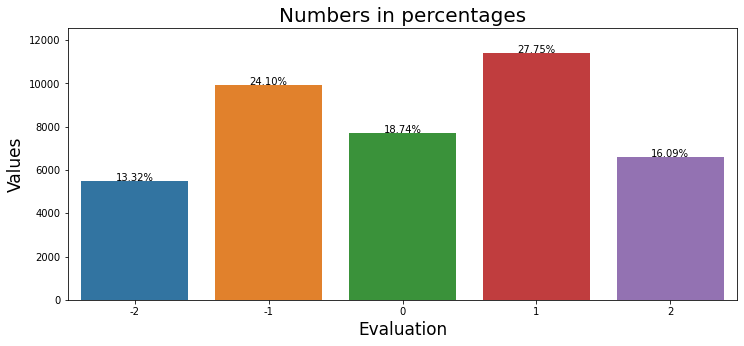

In [15]:
total = len(data)
ax1 = plt.figure(figsize=(12,5))

g = sns.countplot(x='sentiment', data=data)
g.set_title("Numbers in percentages", fontsize=20)
g.set_xlabel("Evaluation", fontsize=17)
g.set_ylabel("Values", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
g.set_ylim(0, max(sizes) * 1.1)

# Processing

In [16]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x >= 0 else 0) 

In [17]:
def clean_t(t):
  t = BeautifulSoup(t, 'lxml').get_text()
  t = re.sub(r"@[A-Za-z0-9]+", ' ', t)
  t = re.sub(r"https?://[A-Za-z0-9./]+", ' ', t)
  t = re.sub(r"[^a-zA-Z.!?]", ' ', t)
  t = re.sub(r" +", ' ', t)
  return t

In [18]:
data_clean = [clean_t(t) for t in data.OriginalTweet]

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:438: MarkupResemblesLocatorWarning:


Heartbreaking." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [19]:
data_labels = data.iloc[:,1].values
data_labels

array([1, 1, 1, ..., 1, 1, 0])

# Tokenization

In [20]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1', trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

2021-11-30 00:07:55.763566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:07:55.765092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:07:55.766187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:07:55.767460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]

In [22]:
encode_sentence("My dog likes strawberries.")

['[CLS]', 'my', 'dog', 'likes', 'straw', '##berries', '.', '[SEP]']

In [23]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

In [24]:
print(data_inputs[0:2])

[['[CLS]', 'ga', '##han', 'and', 'and', '[SEP]'], ['[CLS]', 'advice', 'talk', 'to', 'your', 'neighbours', 'family', 'to', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'of', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'up', 'online', 'shopping', 'accounts', 'if', 'po', '##ss', 'adequate', 'supplies', 'of', 'regular', 'med', '##s', 'but', 'not', 'over', 'order', '[SEP]']]


# Database creation

In [25]:
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

In [26]:
get_ids(tokenizer.tokenize("My dog likes strawberries."))

[2026, 3899, 7777, 13137, 20968, 1012]

In [27]:
np.char.not_equal("[PAD]", "[PAD]")

array(False)

In [28]:
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

In [29]:
get_mask(tokenizer.tokenize("My dog likes strawberries."))

array([1, 1, 1, 1, 1, 1])

In [30]:
def get_segments(tokens):
  seg_ids = []
  current_seg_id = 0
  for tok in tokens:
    seg_ids.append(current_seg_id)
    if tok == "[SEP]":
      current_seg_id = 1 - current_seg_id
  return seg_ids

In [31]:
print(data_inputs[0])

['[CLS]', 'ga', '##han', 'and', 'and', '[SEP]']


In [32]:
get_segments(data_inputs[0])

[0, 0, 0, 0, 0, 0]

In [33]:
my_sent = ["[CLS]"] + tokenizer.tokenize("Roses are red.") + ["[SEP]"]
my_sent

['[CLS]', 'roses', 'are', 'red', '.', '[SEP]']

In [34]:
import tensorflow as tf

In [35]:
bert_layer([
            tf.expand_dims(tf.cast(get_ids(my_sent), tf.int32), 0),
            tf.expand_dims(tf.cast(get_mask(my_sent), tf.int32), 0),
            tf.expand_dims(tf.cast(get_segments(my_sent), tf.int32), 0) 
           ])

2021-11-30 00:08:54.858160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[ 0.963607  ,  0.41511467,  0.66531974, ..., -0.99757344,
          0.28384495, -0.92802364]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6, 1024), dtype=float32, numpy=
 array([[[-1.0402143 ,  0.02023414, -0.54514617, ..., -0.5818614 ,
           0.08679343,  0.6787848 ],
         [-0.92242676,  0.30973858,  0.30103922, ..., -0.5615638 ,
           0.2349521 ,  0.75982934],
         [-0.922934  , -0.17956087, -0.01788273, ..., -0.37173444,
           0.22166437,  0.60791945],
         [-1.1283517 ,  0.03475499,  0.37600914, ..., -0.48268372,
           0.13436893,  0.8829189 ],
         [-0.84755373,  0.26851508, -0.3837716 , ..., -0.30946505,
           0.09428944,  0.7873111 ],
         [-0.90723205,  0.061378  , -0.3057398 , ..., -0.28412077,
           0.2804452 ,  0.53098524]]], dtype=float32)>]

In [36]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key = lambda x: x[2])
sorted_all = [([get_ids(sent_lab[0]),
               get_mask(sent_lab[0]),
               get_segments(sent_lab[0])],
              sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [37]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [38]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, None), ()),
                                       padding_values=(0, 0))

In [39]:
NB_BATCHES = len(sorted_all) // BATCH_SIZE
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

# Model building

In [40]:
class DCNNBERTEmbedding(tf.keras.Model):
    
    def __init__(self,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 name="dcnn"):
        super(DCNNBERTEmbedding, self).__init__(name=name)
        
        self.bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                                         trainable = False)

        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def embed_with_bert(self, all_tokens):
      _, embs = self.bert_layer([all_tokens[:, 0, :],
                                 all_tokens[:, 1, :],
                                 all_tokens[:, 2, :]])
      return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)
        
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Training

In [41]:
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
NB_EPOCHS = 5

In [42]:
Dcnn = DCNNBERTEmbedding(nb_filters=NB_FILTERS,
                         FFN_units=FFN_UNITS,
                         nb_classes=NB_CLASSES,
                         dropout_rate=DROPOUT_RATE)

In [43]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [44]:
history = Dcnn.fit(train_dataset,
                   epochs=NB_EPOCHS)

Epoch 1/5


2021-11-30 00:09:46.394634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1153/1153 [==============================] - 108s 75ms/step - loss: 0.4845 - accuracy: 0.7667
Epoch 2/5
1153/1153 [==============================] - 81s 70ms/step - loss: 0.3791 - accuracy: 0.8291
Epoch 3/5
1153/1153 [==============================] - 82s 70ms/step - loss: 0.3076 - accuracy: 0.8658
Epoch 4/5
1153/1153 [==============================] - 82s 70ms/step - loss: 0.2344 - accuracy: 0.9017
Epoch 5/5
1153/1153 [==============================] - 82s 70ms/step - loss: 0.1849 - accuracy: 0.9227


In [45]:
results = Dcnn.evaluate(test_dataset)
print(results)

128/128 [==============================] - 6s 35ms/step - loss: 0.4172 - accuracy: 0.8398
[0.41717830300331116, 0.83984375]


In [46]:
def get_prediction(sentence):
  tokens = encode_sentence(sentence)

  input_ids = get_ids(tokens)
  input_mask = get_mask(tokens)
  segment_ids = get_segments(tokens)

  inputs = tf.stack(
      [
       tf.cast(input_ids, dtype=tf.int32),
       tf.cast(input_mask, dtype=tf.int32),
       tf.cast(segment_ids, dtype=tf.int32),
      ], axis = 0)
  inputs = tf.expand_dims(inputs, 0)

  output = Dcnn(inputs, training=False)

  sentiment = math.floor(output*2)

  if sentiment == 0:
    print("Output of the model: {}\nPredicted sentiment: negative".format(output))
  elif sentiment == 1:
    print("Output of the model: {}\nPredicted sentiment: positive".format(output))

In [47]:
get_prediction("This actor is very bad.")

Output of the model: [[0.37096685]]
Predicted sentiment: negative


In [48]:
get_prediction("I love dogs.")

Output of the model: [[0.9991968]]
Predicted sentiment: positive


In [49]:
get_prediction("I hate you.")

Output of the model: [[0.00269376]]
Predicted sentiment: negative


In [50]:
get_prediction("I'm good today.")

Output of the model: [[0.9999982]]
Predicted sentiment: positive


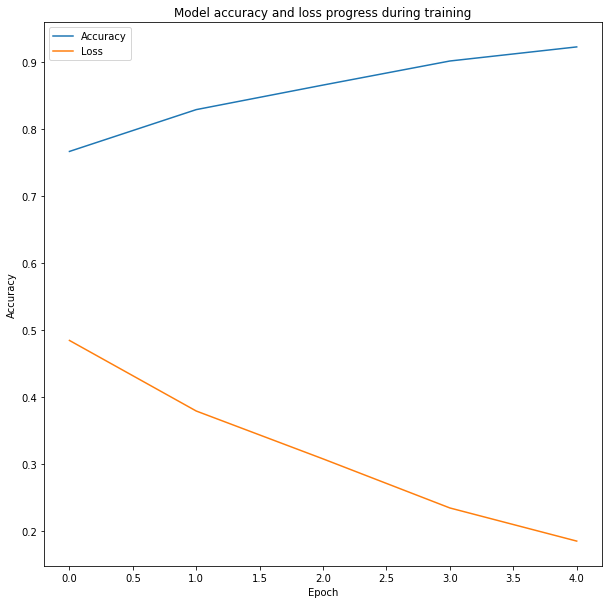

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy and loss progress during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Loss'])

# **If you find this notebook useful, support with an upvote** 👍